# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14487429374014785705
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13415025298250879125
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 16:06:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'InceptionV3'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 5
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4"
T_all_labels = "T0", "T1", "T2", "T3", "T4"

#base_path = ''
base_path = 'gdrive/My Drive/Research_5_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_InceptionV3_None S_InceptionV3_imagenet T_InceptionV3_None T_InceptionV3_imagenet


['S_InceptionV3_imagenet',
 'S_InceptionV3_None',
 'T_InceptionV3_imagenet',
 'T_InceptionV3_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2034, 128, 128, 3) (2034, 1)
(678, 128, 128, 3) (678, 1)
(678, 128, 128, 3) (678, 1)

(2274, 128, 128, 3) (2274, 1)
(758, 128, 128, 3) (758, 1)
(758, 128, 128, 3) (758, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2034, 128, 128, 3) (2034, 5)
(678, 128, 128, 3) (678, 5)
(678, 128, 128, 3) (678, 5)

(2274, 128, 128, 3) (2274, 5)
(758, 128, 128, 3) (758, 5)
(758, 128, 128, 3) (758, 5)


## 2-2. Image Check

xTrain_S image Numbers :  2034
xTrain_S image Numbers // 10 :  203
11


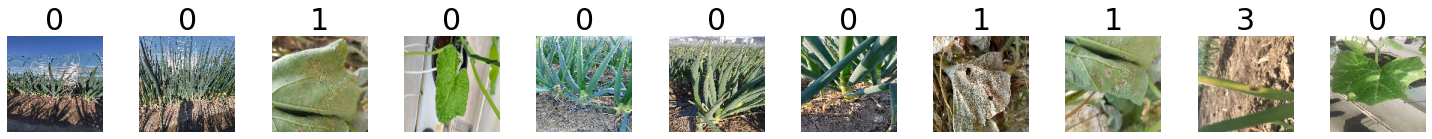

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2274
xTrain_S image Numbers // 10 :  227
11


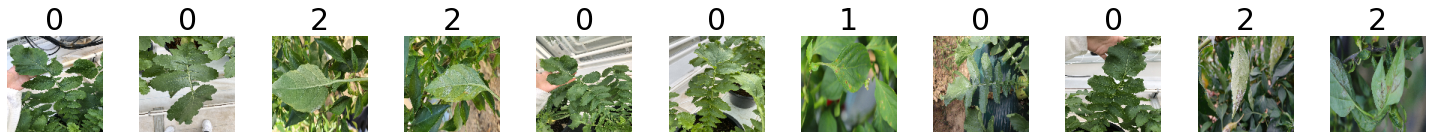

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 24s 214ms/step - loss: 0.9163 - accuracy: 0.6603 - val_loss: 1.8973 - val_accuracy: 0.1386
Epoch 2/100
32/32 [==============================] - 4s 125ms/step - loss: 0.5224 - accuracy: 0.8191 - val_loss: 2.5738 - val_accuracy: 0.1770
Epoch 3/100
32/32 [==============================] - 4s 140ms/step - loss: 0.3962 - accuracy: 0.8555 - val_loss: 2.2598 - val_accuracy: 0.1386
Epoch 4/100
32/32 [==============================] - 4s 119ms/step - loss: 0.2907 - accuracy: 0.8992 - val_loss: 4.3029 - val_accuracy: 0.1770
Epoch 5/100
32/32 [==============================] - 4s 119ms/step - loss: 0.2647 - accuracy: 0.9090 - val_loss: 3.6460 - val_accuracy: 0.1504
Epoch 6/100
32/32 [==============================] - 4s 120ms/step - loss: 0.1995 - accuracy: 0.9331 - val_loss: 5.6709 - val_accuracy: 0.0693
Epoch 7/100
32/32 [==============================] - 4s 125ms/step - loss: 0.1867 - accuracy: 0.9385 - val_loss: 3.4511 - val_accuracy: 0.193

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.916300,0.660275,1.897254,0.138643
1,0.522395,0.819076,2.573770,0.176991
2,0.396156,0.855457,2.259840,0.138643
3,0.290708,0.899213,4.302949,0.176991
4,0.264699,0.909046,3.646043,0.150442
...,...,...,...,...
67,0.118228,0.969027,0.294478,0.929204
68,0.131435,0.966568,3.584753,0.656342
69,0.499867,0.871681,349.064270,0.230089
70,0.295759,0.907080,2.433559,0.851032


Minimum validation loss: 0.13784976303577423
Maximum validation accuracy: 0.9646017551422119


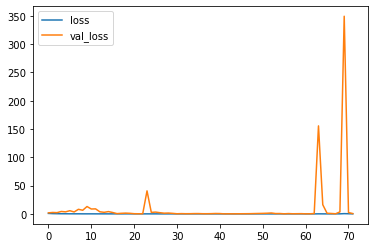

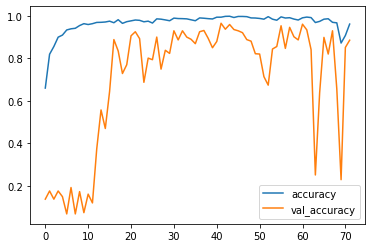

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
22/22 [==============================] - 1s 40ms/step - loss: 0.1627 - accuracy: 0.9587
test loss, test acc: [0.16267701983451843, 0.9587020874023438]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

22/22 [==============================] - 2s 25ms/step


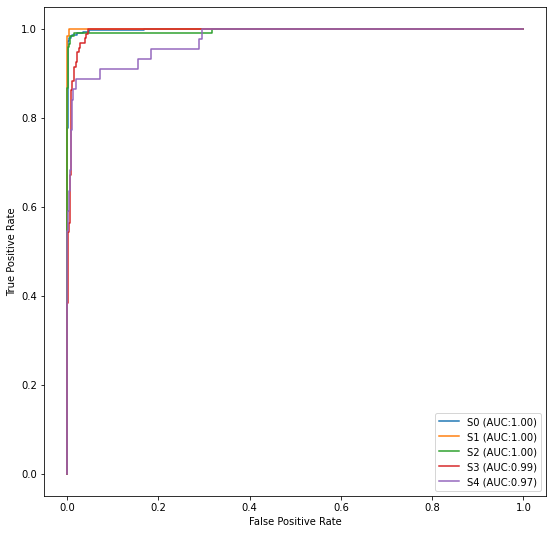

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

87924736/87910968 [==============================] - 1s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 15s 188ms/step - loss: 0.5649 - accuracy: 0.8102 - val_loss: 3.9838 - val_accuracy: 0.1504
Epoch 2/100
32/32 [==============================] - 4s 128ms/step - loss: 0.2058 - accuracy: 0.9322 - val_loss: 1.7864 - val_accuracy: 0.2891
Epoch 3/100
32/32 [==============================] - 4s 127ms/step - loss: 0.1122 - accuracy: 0.9656 - val_loss: 0.9764 - val_accuracy: 0.7478
Epoch 4/100
32/32 [==============================] - 4s 122ms/step - loss: 0.1272 - accuracy: 0.9631 - val_loss: 6.9582 - val_accuracy: 0.5457
Epoch 5/100
32/32 [==============================] - 4s 127ms/step - loss: 0.0861 - accuracy: 0.9759 - val_loss: 0.8861 - val_accuracy: 0.8304
Epoch 6/100
32/32 [==============================] - 4s 128ms/step - loss: 0.0904 - accuracy: 0.9739 - val_loss: 0.3497 - val_accuracy: 0.9425
Epoch 7/100
32/32 [==============================] - 4s 123ms/step - loss: 0.0475 - accuracy: 0.9862 - val_loss: 0.3594 - val_accuracy: 0.929

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.564948,0.810226,3.983845,0.150442
1,0.205809,0.932153,1.786448,0.289086
2,0.112197,0.965585,0.976419,0.747788
3,0.127188,0.963127,6.958214,0.545723
4,0.086104,0.975910,0.886137,0.830383
5,0.090355,0.973943,0.349682,0.942478
6,0.047452,0.986234,0.359409,0.929204
7,0.046084,0.986234,0.272905,0.943953
8,0.043258,0.987217,0.720775,0.834808
9,0.053527,0.982301,0.281138,0.935103


Minimum validation loss: 0.04084917530417442
Maximum validation accuracy: 0.9882006049156189


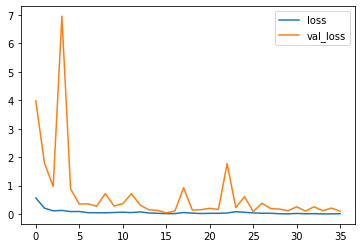

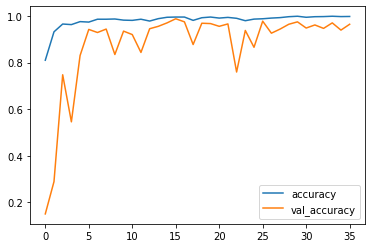

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
22/22 [==============================] - 1s 29ms/step - loss: 0.1041 - accuracy: 0.9764
test loss, test acc: [0.10405191034078598, 0.976401150226593]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

22/22 [==============================] - 2s 25ms/step


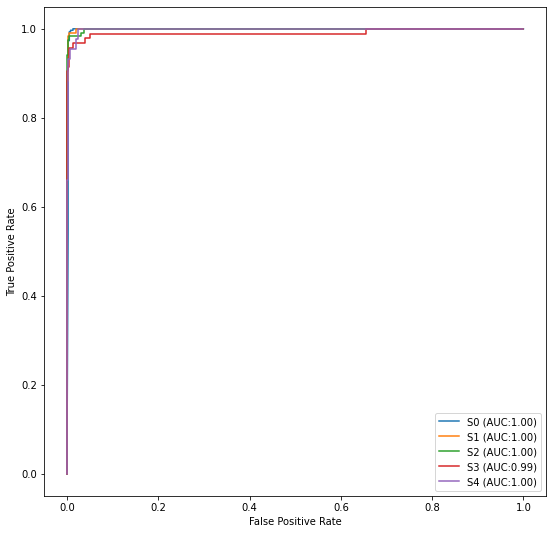

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 16s 208ms/step - loss: 1.0758 - accuracy: 0.5844 - val_loss: 1.6189 - val_accuracy: 0.2111
Epoch 2/100
36/36 [==============================] - 4s 120ms/step - loss: 0.7284 - accuracy: 0.7291 - val_loss: 3.9948 - val_accuracy: 0.2111
Epoch 3/100
36/36 [==============================] - 4s 122ms/step - loss: 0.6010 - accuracy: 0.7823 - val_loss: 3.5256 - val_accuracy: 0.2111
Epoch 4/100
36/36 [==============================] - 4s 121ms/step - loss: 0.5056 - accuracy: 0.8171 - val_loss: 4.5769 - val_accuracy: 0.2111
Epoch 5/100
36/36 [==============================] - 4s 120ms/step - loss: 0.4393 - accuracy: 0.8404 - val_loss: 3.4626 - val_accuracy: 0.1398
Epoch 6/100
36/36 [==============================] - 4s 120ms/step - loss: 0.4031 - accuracy: 0.8492 - val_loss: 6.1419 - val_accuracy: 0.2111
Epoch 7/100
36/36 [==============================] - 4s 119ms/step - loss: 0.3515 - accuracy: 0.8690 - val_loss: 2.8373 - val_accuracy: 0.211

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.075787,0.584433,1.618915,0.211082
1,0.728374,0.729112,3.994838,0.211082
2,0.600981,0.782322,3.525557,0.211082
3,0.505616,0.817062,4.576947,0.211082
4,0.439290,0.840369,3.462627,0.139842
...,...,...,...,...
95,0.029313,0.991205,1.042470,0.823219
96,0.023330,0.992964,1.309709,0.792876
97,0.035175,0.989446,2.160889,0.651715
98,0.037758,0.988566,0.898940,0.795515


Minimum validation loss: 0.6050593256950378
Maximum validation accuracy: 0.8905013203620911


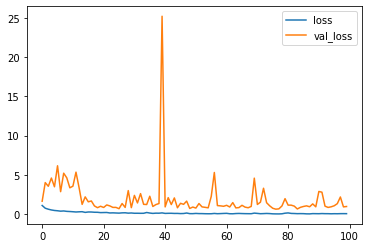

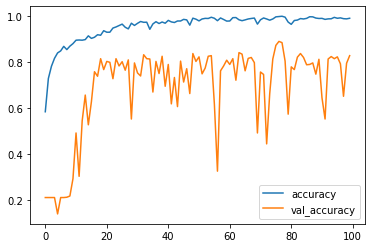

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
24/24 [==============================] - 1s 39ms/step - loss: 0.8686 - accuracy: 0.8377
test loss, test acc: [0.8685676455497742, 0.837730884552002]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

24/24 [==============================] - 2s 25ms/step


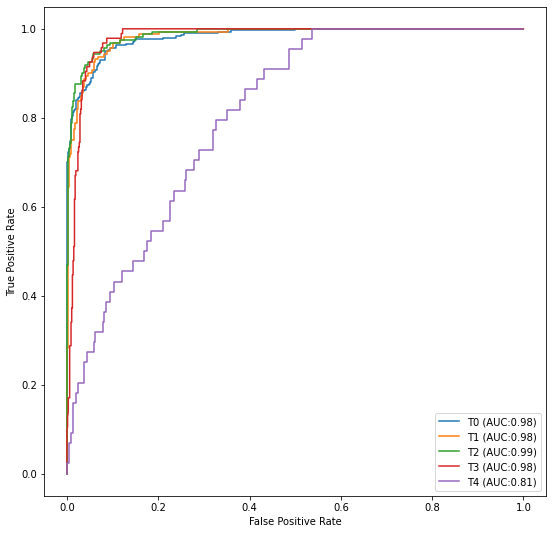

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 14s 173ms/step - loss: 0.6920 - accuracy: 0.7432 - val_loss: 10.1293 - val_accuracy: 0.1214
Epoch 2/100
36/36 [==============================] - 4s 119ms/step - loss: 0.3084 - accuracy: 0.8773 - val_loss: 3.1196 - val_accuracy: 0.0844
Epoch 3/100
36/36 [==============================] - 4s 124ms/step - loss: 0.1875 - accuracy: 0.9332 - val_loss: 2.7531 - val_accuracy: 0.4261
Epoch 4/100
36/36 [==============================] - 4s 124ms/step - loss: 0.2306 - accuracy: 0.9213 - val_loss: 3.4363 - val_accuracy: 0.6240
Epoch 5/100
36/36 [==============================] - 4s 124ms/step - loss: 0.1604 - accuracy: 0.9472 - val_loss: 3.3388 - val_accuracy: 0.6557
Epoch 6/100
36/36 [==============================] - 4s 125ms/step - loss: 0.1142 - accuracy: 0.9631 - val_loss: 0.7537 - val_accuracy: 0.8417
Epoch 7/100
36/36 [==============================] - 4s 120ms/step - loss: 0.0806 - accuracy: 0.9780 - val_loss: 1.1242 - val_accuracy: 0.77

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.692014,0.743184,10.129270,0.121372
1,0.308428,0.877309,3.119636,0.084433
2,0.187468,0.933157,2.753143,0.426121
3,0.230645,0.921284,3.436291,0.624011
4,0.160396,0.947230,3.338771,0.655673
5,0.114160,0.963061,0.753748,0.841689
6,0.080639,0.978012,1.124182,0.777045
7,0.096994,0.967898,1.571287,0.872032
8,0.175724,0.941513,0.890454,0.784960
9,0.117355,0.963940,6.768111,0.464380


Minimum validation loss: 0.46154236793518066
Maximum validation accuracy: 0.8984168767929077


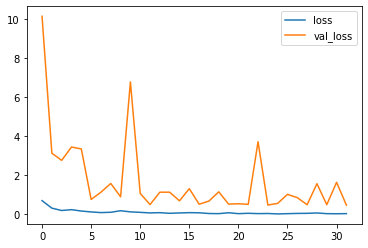

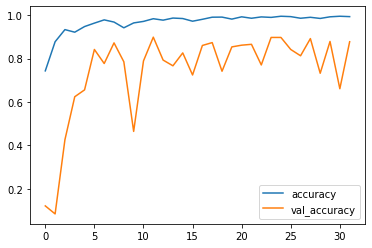

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
24/24 [==============================] - 1s 29ms/step - loss: 0.4510 - accuracy: 0.8997
test loss, test acc: [0.45101800560951233, 0.8997361660003662]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

24/24 [==============================] - 2s 24ms/step


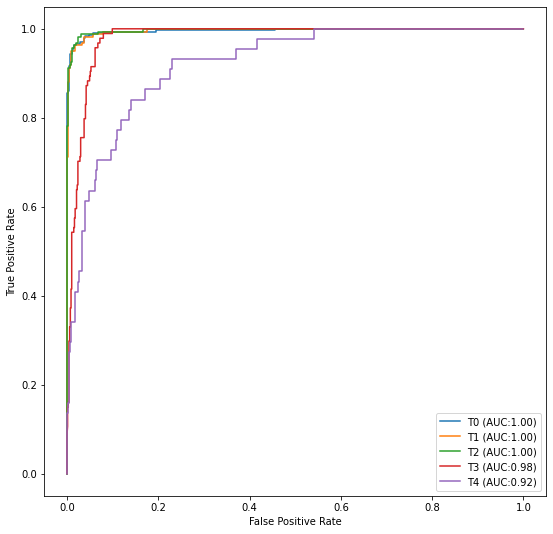

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_InceptionV3_None
test loss, test acc: [0.16267701983451843, 0.9587020874023438]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_InceptionV3_imagenet
test loss, test acc: [0.10405191034078598, 0.976401150226593]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_InceptionV3_None
test loss, test acc: [0.8685676455497742, 0.837730884552002]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_InceptionV3_imagenet
test loss, test acc: [0.45101800560951233, 0.8997361660003662]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_InceptionV3_None →→→ Target Test
24/24 [==============================] - 1s 29ms/step - loss: 3.9704 - accuracy: 0.3140
test loss, test acc: [3.970414638519287, 0.3139841556549072]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_InceptionV3_imagenet →→→ Target Test
24/24 [==============================] - 1s 29ms/step - loss: 4.2780 - accuracy: 0.2559
test loss, test acc: [4.278047561645508, 0.2559366822242737]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_InceptionV3_None →→→ Source Test
22/22 [==============================] - 1s 29ms/step - loss: 5.4925 - accuracy: 0.4189
test loss, test acc: [5.492465496063232, 0.41887906193733215]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_InceptionV3_imagenet →→→ Source Test
22/22 [==============================] - 1s 30ms/step - loss: 3.8656 - accuracy: 0.3260
test loss, test acc: [3.8656423091888428, 0.3259586989879608]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )